In [7]:
from model import *
%matplotlib inline
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 256
import shutil
import os
import numpy as np
import torch
from torch import nn, optim, autograd
import torch.nn.init as init
import torch.nn.functional as F
import torchvision.utils as vutils
import torch.utils.data as udata
import torchvision.datasets as vdatasets
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation



In [2]:
dataroot = 'data/'
workers = 8
# batch size map {4:32, 8:32, 16:32, 32:16, 64:16, 128:16, 256:12, 512:3, 1024:1}
batch_size = 32
image_size = 4
nc = 3
nz = 512
num_epochs = 300
device = torch.device('cuda:0')

In [3]:
torch.cuda.is_available()

True

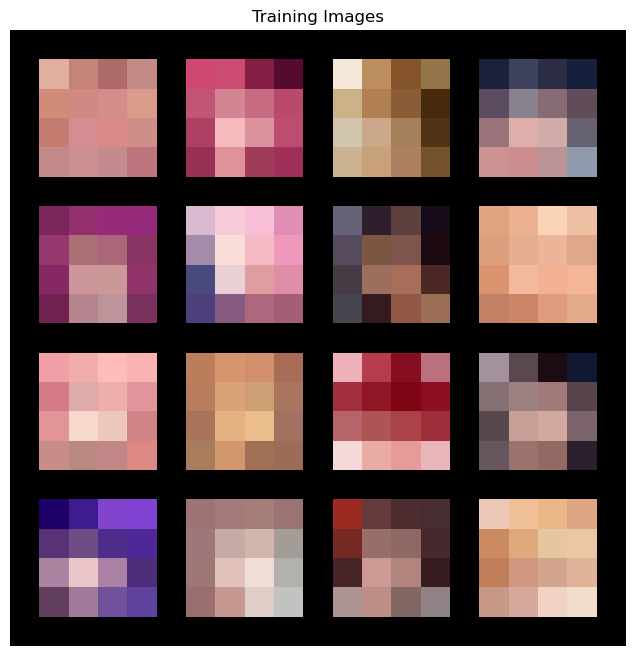

In [4]:
def modify_data(root, image_size):
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset = vdatasets.ImageFolder(root=root, transform=transform)
    return dataset

dataset = modify_data(dataroot, image_size)

dataloader = udata.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:16], padding=1, normalize=True, nrow=4).cpu(),(1,2,0)))
plt.show()

In [8]:
netG = Generator(nz).to(device)
netD = Distriminator().to(device)

In [9]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
criterion = nn.BCEWithLogitsLoss()
real_label = 1
fake_label = 0
lr = 0.001
beta1 = 0.0
g_optimizer = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.99))
d_optimizer = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.99))

In [ ]:
experiment_path = 'check_point/pggan'
img_list = []
G_losses = []
D_losses = []
D_losses_tmp = []
Grad_penalty = []
i = 0
iters = 0
total_iters = 0
expand = 0
n_critic = 1
step = 0
alpha = 0
CLAMP = 0.01
one = torch.FloatTensor([1]).cuda()
mone = one * -1
print('Training start!')
for epoch in range(num_epochs):
    if epoch != 0 and epoch % 50 == 0:
        alpha = 0
        iters = 0
        expand += 1
        if expand >= 3:
            batch_size = 16
        if expand > 5:
            alpha = 1
            expand = 5
        dataset = modify_data(dataroot, image_size * 2 ** expand)
        dataloader = udata.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    for i, data in enumerate(dataloader):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        if step < n_critic:
            netD.zero_grad()
            for p in netD.parameters():
                p.requires_grad = True
#                 p.data.clamp_(-CLAMP, CLAMP)
            output = netD(real_cpu, expand, alpha).view(-1)
            errD_real = (output.mean() - 0.001 * (output ** 2).mean()).view(1)
            errD_real.backward(mone)
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise, expand, alpha)
            output = netD(fake.detach(), expand, alpha).view(-1)
            errD_fake = output.mean().view(1)
            errD_fake.backward(one)
            eps = torch.rand(b_size, 1, 1, 1, device=device)
            x_hat = eps * real_cpu.data + (1 - eps) * fake.data
            x_hat.requires_grad = True
            hat_predict = netD(x_hat, expand, alpha)
            grad_x_hat = autograd.grad(outputs=hat_predict.sum(), inputs=x_hat, create_graph=True)[0]
            grad_penalty = ((grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()
            grad_penalty = 10 * grad_penalty
            grad_penalty.backward()
            errD = errD_real - errD_fake
            d_optimizer.step()
            D_losses_tmp.append(errD.item())
            step += 1
        else:
            for p in netD.parameters():
                p.requires_grad = False
            netG.zero_grad()
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake = netG(noise, expand, alpha)
            output = netD(fake, expand, alpha).view(-1)
            errG = -output.mean().view(1)
            errG.backward()
            g_optimizer.step()
            D_losses.append(np.mean(D_losses_tmp))
            G_losses.append(errG.item())
            D_losses_tmp = []
            step = 0
        if (total_iters+1) % 200 == 0:
            print('[%d/%d][%d/%d](%d)\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f\tGrad: %.4f'
                  % (epoch+1, num_epochs, i+1, len(dataloader), total_iters + 1,
                     errD.item(), errG.item(), errD_real.data.mean(), errD_fake.data.mean(), grad_penalty.data))
        # Check how the generator is doing by saving G's output on fixed_noise
        if (total_iters % 5000 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise, expand, alpha).detach().cpu()
            img = vutils.make_grid(fake, padding=2, normalize=True)
            vutils.save_image(img, 'check_point/pggan/fake_image/fake_iter_{0}.jpg'.format(total_iters))
            img_list.append(img)

        iters += 1
        total_iters += 1
        if (epoch + 1) % 50 == 0:
            torch.save(netG.state_dict(), '{0}/netG_epoch_{1}.pth'.format(experiment_path, epoch+1))
            torch.save(netD.state_dict(), '{0}/netD_epoch_{1}.pth'.format(experiment_path, epoch+1))